# Import the required modules

In [1]:
!pip install git+https://github.com/goolig/dsClass.git

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-b40halzl
  Running command git clone -q https://github.com/goolig/dsClass.git /tmp/pip-req-build-b40halzl
  Resolved https://github.com/goolig/dsClass.git to commit 67567d1d71a8a747c8a68c621045fe53ff139103
     |████████████████████████████████| 278 kB 918 kB/s 
  Created wheel for dsClass: filename=dsClass-1.0.27-py3-none-any.whl size=16372733 sha256=518ebfbb7356a6cb0567274c8f4f02a6ba22017953562d766eb92caf2b77dfb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-q24gr9tc/wheels/cc/7d/ca/f5036d591d94a23e6ab49777866b7fc723500ce0dcdb2a9b2e
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=1bfb97076645aada7b54b2de08cc16c7e6a90c3d802465754205ace75d3dc583
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built dsClass pydotplus


In [2]:

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectKBest, SelectFpr
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from dsClass.path_helper import *



In [3]:
ts_file_path = get_file_path('ts_data.csv')
ts_data = pd.read_csv(ts_file_path)
print(ts_data.shape)
ts_data

(204000, 9)


,d_id,time,bb_count,r-w_rate,reconsects_count,recovbydrv_count,xfer_rate,bb_diffs,fail
0,1,V1,-5,14,0,9,85,0,True
1,1,V2,5,15,0,17,76,0,True
2,1,V3,14,11,0,24,87,0,True
3,1,V4,22,7,0,31,75,0,True
4,1,V5,29,11,0,42,81,0,True
...,...,...,...,...,...,...,...,...,...
203995,10200,V16,165,7,29,185,83,0,False
203996,10200,V17,171,7,29,190,81,0,False
203997,10200,V18,182,11,31,198,96,2,False
203998,10200,V19,190,12,31,204,81,0,False


# Load the time-series data and lookt at the features statistics

In [4]:
ts_data.groupby('fail').describe()

d_id                                                        \
          count    mean          std    min      25%     50%      75%   
fail                                                                    
False  200000.0  5200.5  2886.758548  201.0  2700.75  5200.5  7700.25   
True     4000.0   100.5    57.741523    1.0    50.75   100.5   150.25   

                bb_count              ... xfer_rate         bb_diffs           \
           max     count        mean  ...       75%    max     count     mean   
fail                                  ...                                       
False  10200.0  200000.0   97.986965  ...      83.0  148.0  200000.0  3.01709   
True     200.0    4000.0  122.358000  ...     104.0  145.0    4000.0  1.04475   

                                           
            std  min  25%  50%  75%   max  
fail                                       
False  2.466513  0.0  1.0  3.0  4.0  22.0  
True   1.390227  0.0  0.0  0.0  2.0   9.0  

[2 rows x 56 columns]

# Plot the time series data

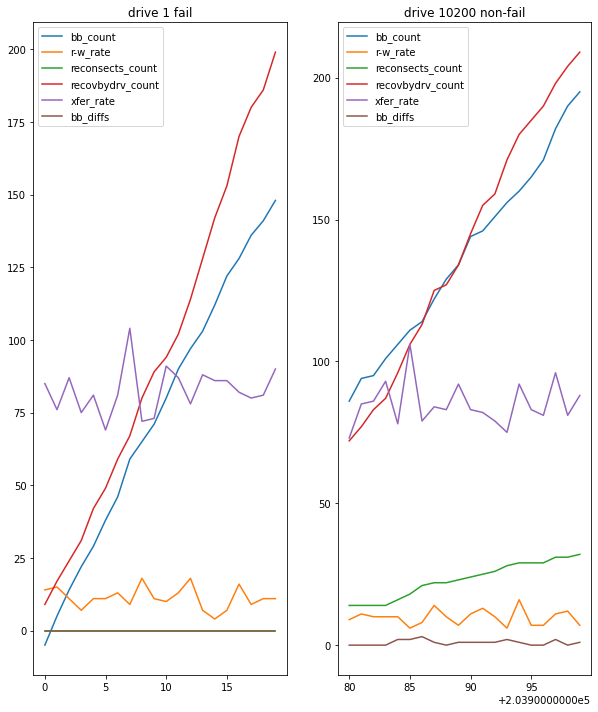

In [5]:
original_features = ['bb_count', 'r-w_rate', 'reconsects_count',
       'recovbydrv_count', 'xfer_rate', 'bb_diffs']

fig, axes = plt.subplots(nrows=1, ncols=2)

ts_data.loc[ts_data['d_id']==1,original_features].plot(figsize=(10,12), title='drive '+str(1)+' fail', ax=axes[0])

num_drives = ts_data['d_id'].unique().shape[0]
#num_drives

ts_data.loc[ts_data['d_id']==num_drives,original_features].plot(figsize=(10,12), title='drive '+str(num_drives)+' non-fail', ax=axes[1])
plt.legend()

# Engineer the time-series features

For each Create the aggregated features (mean, median, variance, minimum and naximum):
* for each sn
* for each feature
* for each aggregation type
        aggregate the 20 daily samples into one aggregated sample  

**#Q1**
**Data set, grouped by d_id**

In [6]:
#Q1
mean_ts=ts_data.groupby(['d_id','fail']).mean()
median_ts=ts_data.groupby(['d_id','fail']).median()
var_ts=ts_data.groupby(['d_id','fail']).var()
max_ts=ts_data.groupby(['d_id','fail']).max().drop('time',axis=1)
min_ts=ts_data.groupby(['d_id','fail']).min().drop('time',axis=1)


mean_median=median_ts.merge(mean_ts, on=['d_id','fail'],suffixes=('-medain','-mean'))
mean_median_max=mean_median.merge(max_ts, on=['d_id','fail'],suffixes=('','-max'))
mean_median_max_min=mean_median_max.merge(min_ts, on=['d_id','fail'],suffixes=('','-min'))
mean_median_max_min_var=mean_median_max_min.merge(var_ts, on=['d_id','fail'],suffixes=('','-var'))

mean_median_max_min_var



,,bb_count-medain,r-w_rate-medain,reconsects_count-medain,recovbydrv_count-medain,xfer_rate-medain,bb_diffs-medain,bb_count-mean,r-w_rate-mean,reconsects_count-mean,recovbydrv_count-mean,...,reconsects_count-min,recovbydrv_count-min,xfer_rate-min,bb_diffs-min,bb_count-var,r-w_rate-var,reconsects_count-var,recovbydrv_count-var,xfer_rate-var,bb_diffs-var
d_id,fail,,,,,,,,,,,,,,,,,,,,,
1,True,75.5,11.0,0.0,91.5,81.5,0.0,75.05,11.30,0.00,96.75,...,0,9,69,0,2307.313158,13.694737,0.000000,3623.250000,63.515789,0.000000
2,True,97.0,18.0,3.0,124.0,83.5,0.0,102.35,18.80,3.00,121.70,...,3,35,69,0,1794.976316,14.905263,0.000000,3033.168421,51.944737,0.000000
3,True,152.0,21.5,5.0,170.0,96.5,0.0,153.30,20.00,5.00,166.00,...,5,51,77,0,3903.905263,29.368421,0.000000,5618.736842,72.094737,0.000000
4,True,99.0,19.5,-2.0,151.5,114.0,0.0,96.05,20.00,-2.00,154.90,...,-2,3,94,0,5173.839474,8.000000,0.000000,10027.042105,112.976316,0.000000
5,True,146.0,9.5,31.5,145.0,93.0,3.0,140.45,9.55,29.05,149.15,...,6,42,71,0,3759.628947,14.155263,181.734211,4773.186842,83.671053,2.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,False,115.5,8.0,13.5,146.5,90.5,1.0,110.00,8.55,12.15,146.40,...,6,20,69,0,3385.263158,15.944737,14.765789,6692.884211,107.357895,0.344737
10197,False,127.0,15.5,53.0,63.5,82.0,5.0,123.40,15.20,53.55,58.55,...,10,28,70,1,3008.252632,25.536842,881.418421,302.681579,69.631579,5.852632
10198,False,56.5,10.0,32.0,226.0,71.0,2.0,52.95,11.15,31.70,218.70,...,8,41,55,0,259.734211,10.765789,218.852632,11011.273684,113.186842,2.568421


# Load the cofiguration data

In [7]:
conf_file_path = get_file_path('conf_data.csv')
conf_data = pd.read_csv(conf_file_path)
conf_data

,d_id,age,capacity,model,fail
0,1,15,1TB,Hitachi,True
1,2,23,1TB,Fujitsu,True
2,3,23,1TB,Seagate,True
3,4,14,1TB,Hitachi,True
4,5,18,600GB,Hitachi,True
...,...,...,...,...,...
10195,10196,16,1TB,Seagate,False
10196,10197,25,600GB,Hitachi,False
10197,10198,23,300GB,Hitachi,False
10198,10199,13,600GB,Seagate,False


# Look at the features\labels distribution

<AxesSubplot:title={'center':'age'}, xlabel='[fail]'>

<Figure size 432x288 with 0 Axes>

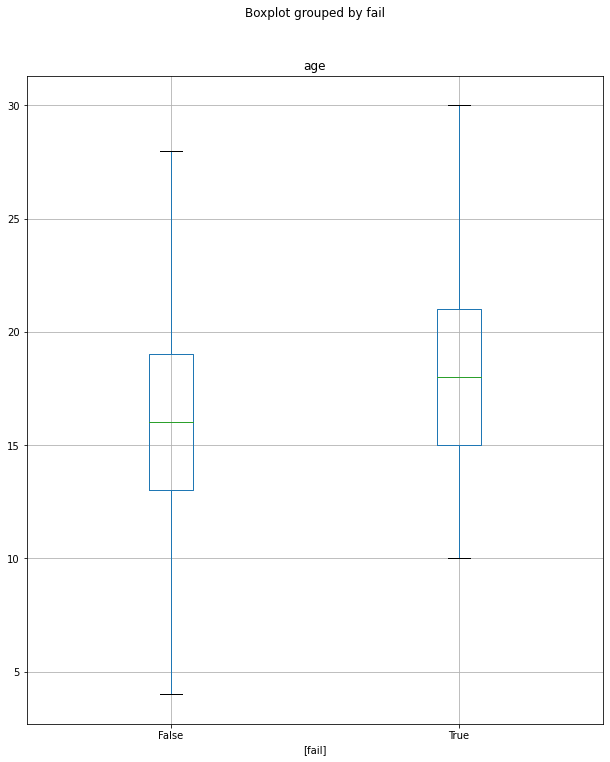

In [8]:
plt.figure()
conf_data[['age', 'fail']].boxplot(by='fail', figsize=(10,12), sym='')

<AxesSubplot:xlabel='model'>

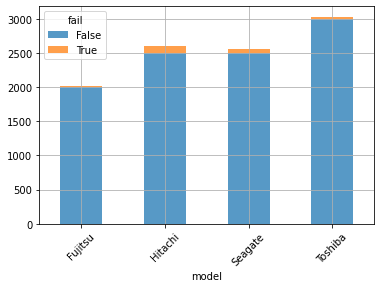

In [9]:
g = conf_data.groupby(["model", "fail"])['d_id'].count().unstack('fail')
g.plot(kind="bar", stacked=True, grid=True, alpha=0.75, rot=45)

# Handle categorical data 

For the decision tree algorithm, map the categorical features to numeric with:
* "Change_capacity" function for "capacity" column
* "pd.get_dummies" function for "model" column


In [10]:
#Q2
def change_capacity(data):
    # A function that receives a data frame and a column name as input and map the categorical capacity feature to numeric 
    di = dict(zip(conf_data["capacity"].unique(), [1000, 600, 300]))

    return data.replace({"capacity": di}, inplace=False)


In [11]:
new_conf_data = change_capacity(conf_data)
new_conf_data=pd.get_dummies(new_conf_data,columns=['model'])
new_conf_data

,d_id,age,capacity,fail,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba
0,1,15,1000,True,0,1,0,0
1,2,23,1000,True,1,0,0,0
2,3,23,1000,True,0,0,1,0
3,4,14,1000,True,0,1,0,0
4,5,18,600,True,0,1,0,0
...,...,...,...,...,...,...,...,...
10195,10196,16,1000,False,0,0,1,0
10196,10197,25,600,False,0,1,0,0
10197,10198,23,300,False,0,1,0,0
10198,10199,13,600,False,0,0,1,0


# Merge the aggregated time-series and the configuration datasets

In [12]:
#Q3
merged_data_frame=new_conf_data.merge(mean_median_max_min_var,on='d_id')
merged_data_frame_withoutDid=merged_data_frame.drop(['d_id','fail'],axis=1)
onlyFails=merged_data_frame['fail']
merged_data_frame_withoutDid


,age,capacity,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba,bb_count-medain,r-w_rate-medain,reconsects_count-medain,recovbydrv_count-medain,...,reconsects_count-min,recovbydrv_count-min,xfer_rate-min,bb_diffs-min,bb_count-var,r-w_rate-var,reconsects_count-var,recovbydrv_count-var,xfer_rate-var,bb_diffs-var
0,15,1000,0,1,0,0,75.5,11.0,0.0,91.5,...,0,9,69,0,2307.313158,13.694737,0.000000,3623.250000,63.515789,0.000000
1,23,1000,1,0,0,0,97.0,18.0,3.0,124.0,...,3,35,69,0,1794.976316,14.905263,0.000000,3033.168421,51.944737,0.000000
2,23,1000,0,0,1,0,152.0,21.5,5.0,170.0,...,5,51,77,0,3903.905263,29.368421,0.000000,5618.736842,72.094737,0.000000
3,14,1000,0,1,0,0,99.0,19.5,-2.0,151.5,...,-2,3,94,0,5173.839474,8.000000,0.000000,10027.042105,112.976316,0.000000
4,18,600,0,1,0,0,146.0,9.5,31.5,145.0,...,6,42,71,0,3759.628947,14.155263,181.734211,4773.186842,83.671053,2.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,16,1000,0,0,1,0,115.5,8.0,13.5,146.5,...,6,20,69,0,3385.263158,15.944737,14.765789,6692.884211,107.357895,0.344737
10196,25,600,0,1,0,0,127.0,15.5,53.0,63.5,...,10,28,70,1,3008.252632,25.536842,881.418421,302.681579,69.631579,5.852632
10197,23,300,0,1,0,0,56.5,10.0,32.0,226.0,...,8,41,55,0,259.734211,10.765789,218.852632,11011.273684,113.186842,2.568421
10198,13,600,0,0,1,0,88.0,7.5,50.0,153.5,...,11,38,49,1,1597.631579,9.568421,566.513158,5137.431579,46.252632,3.357895


# Select the 10 most informative features and transform the data

In [13]:
#Q4
selectedKBest=SelectKBest(f_classif,k=10).fit_transform(merged_data_frame_withoutDid,onlyFails)
selectedKBest

array([[11.  , 81.5 , 11.3 , ...,  4.  ,  0.  , 69.  ],
       [18.  , 83.5 , 18.8 , ..., 13.  ,  3.  , 69.  ],
       [21.5 , 96.5 , 20.  , ..., 10.  ,  5.  , 77.  ],
       ...,
       [10.  , 71.  , 11.15, ...,  5.  ,  8.  , 55.  ],
       [ 7.5 , 62.5 ,  6.9 , ...,  2.  , 11.  , 49.  ],
       [10.  , 83.  ,  9.75, ...,  6.  , 14.  , 73.  ]])

# Train a Decision tree classifier 

Since we are learning and testing on the same set we will limit the maximum depth parameter to 5 to prevent overfitting

In [14]:
#Q5
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(selectedKBest,onlyFails,random_state=0,shuffle=True)

In [15]:
print(type(y_train))
print(y_train.head())
print(X_train)

<class 'pandas.core.series.Series'>
8311    False
318     False
4777    False
7366    False
9675    False
Name: fail, dtype: bool
[[ 9.   84.5   9.5  ...  4.   12.   66.  ]
 [13.   85.   12.7  ...  7.    6.   74.  ]
 [ 8.   78.    8.6  ...  4.   11.   63.  ]
 ...
 [10.   70.   10.05 ...  5.    8.   56.  ]
 [ 7.   65.    7.6  ...  5.    6.   57.  ]
 [14.   71.   13.95 ...  7.   13.   59.  ]]


In [16]:
from sklearn.metrics import roc_auc_score
clf=DecisionTreeClassifier()
clf.max_depth=20
clf.fit(X_train,y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print("Area under curve: "+str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))


Accuracy of Decision Tree classifier on training set: 0.99
Area under curve: 0.8583433373349341


# Make the prediction and plot the confusion matrix
https://en.wikipedia.org/wiki/Confusion_matrix

* Change "max_depth" paramter to see what happens to model results


Accuracy of Decision Tree classifier on test set: 0.99
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2499
        True       0.63      0.73      0.67        51

    accuracy                           0.99      2550
   macro avg       0.81      0.86      0.83      2550
weighted avg       0.99      0.99      0.99      2550



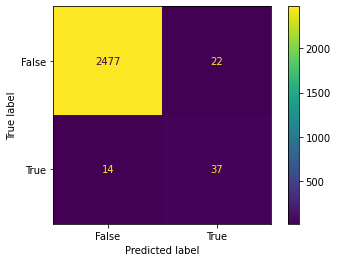

In [17]:
#Q6
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

predictions=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test]
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test,predictions))

# Find the error

Guy claims that if you followed the instruction until Q6 then there is a mistake in the notebook and that we can not rely on the reported performance when information about a new hard drive will arrive

1. Explain in words what is the error 
1. Explain in words what you have to change in order to fix the error
1. Fix the error. Submit a fixed notebook only

# #Q7-Answer:
1. As we can see, we have much more samples that thier output is False then samples that their output is Ture. Much more samples that the Hard-Disk didn't fail than those that the Hard-Drive failed.
The rate is significant and as a result, the model is trained to be accurate about Pass samples then about Fail samples.

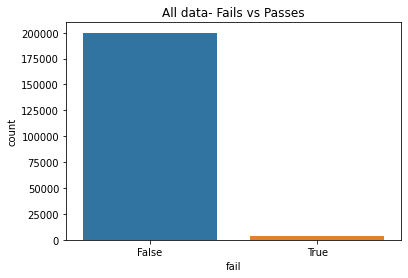

In [18]:
#Q7
import seaborn as sns
#We can also visualize it:
sns.countplot(x=ts_data['fail'],label="Count")
plt.title("All data- Fails vs Passes")
plt.show()

Because the models is trained on major amount of Pass samples, and the test set is also with a great amount of Pass samples, the chance that the model will predict Pass, and that it will be correct, is very high.

Count train set


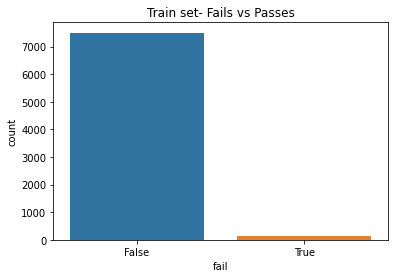

In [19]:
print("Count train set")
sns.countplot(x=y_train,label="Count train set")
plt.title("Train set- Fails vs Passes")
plt.show()

Count test set


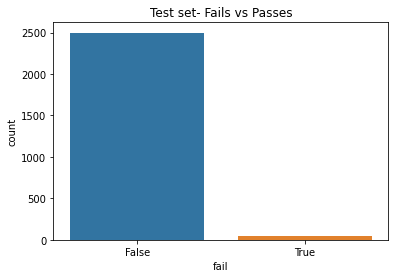

In [20]:
print("Count test set")
sns.countplot(x=y_test,label="Count test set")
plt.title("Test set- Fails vs Passes")
plt.show()

2. Some possible solutions to the situation are:
* Oversample the smallest class
* Undersample the biggest dataset
* Class Weights

We used this source: https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704

Accuracy of Decision Tree classifier on training set: 1.00
Area under curve: 0.9970737135212261
Accuracy of Decision Tree classifier on test set: 1.00
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      2479
        True       0.99      1.00      1.00      2521

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



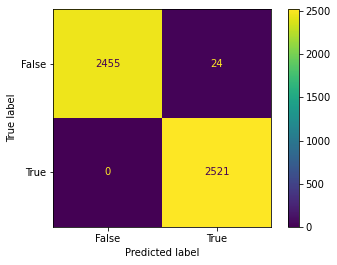

In [21]:
#Oversample
from imblearn.over_sampling import RandomOverSampler
over_sampler=RandomOverSampler(random_state=42)
X_res_oversample,y_res_oversample=over_sampler.fit_resample(selectedKBest,onlyFails)
X_train_oversample,X_test_oversample,y_train_oversample,y_test_oversample=train_test_split(X_res_oversample,y_res_oversample,random_state=0,shuffle=True)
clf.fit(X_train_oversample,y_train_oversample)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))
print("Area under curve: "+str(roc_auc_score(y_test_oversample, clf.predict_proba(X_test_oversample)[:, 1])))
predictions=clf.predict(X_test_oversample)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test_oversample]
plot_confusion_matrix(clf,X_test_oversample,y_test_oversample)
print(classification_report(y_test_oversample,predictions))

Accuracy of Decision Tree classifier on training set: 0.98
Area under curve: 0.9818181818181818
Accuracy of Decision Tree classifier on test set: 0.98
              precision    recall  f1-score   support

       False       1.00      0.96      0.98        55
        True       0.96      1.00      0.98        45

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



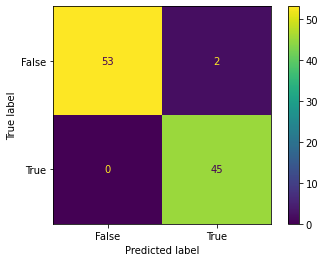

In [22]:
#Undersample
from imblearn.under_sampling import RandomUnderSampler
under_sampler=RandomUnderSampler(random_state=42)
X_res_undersample,y_res_undersample=under_sampler.fit_resample(selectedKBest,onlyFails)
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample=train_test_split(X_res_undersample,y_res_undersample,random_state=0,shuffle=True)
clf.fit(X_train_undersample,y_train_undersample)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))
print("Area under curve: "+str(roc_auc_score(y_test_undersample, clf.predict_proba(X_test_undersample)[:, 1])))
predictions=clf.predict(X_test_undersample)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test_undersample]
plot_confusion_matrix(clf,X_test_undersample,y_test_undersample)
print(classification_report(y_test_undersample,predictions))

Accuracy of Decision Tree classifier on training set: 0.95
Area under curve: 0.9221492518576059
Accuracy of Decision Tree classifier on test set: 0.95
              precision    recall  f1-score   support

       False       1.00      0.96      0.98      2499
        True       0.29      0.86      0.43        51

    accuracy                           0.95      2550
   macro avg       0.64      0.91      0.70      2550
weighted avg       0.98      0.95      0.97      2550



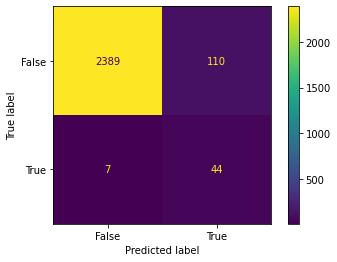

In [23]:
#Class weights- balanced Decision Tree
X_train,X_test,y_train,y_test=train_test_split(selectedKBest,onlyFails,random_state=0,shuffle=True)
clf=DecisionTreeClassifier(class_weight='balanced')
clf.max_depth=5
clf.fit(X_train,y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print("Area under curve: "+str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
predictions=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test]
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test,predictions))

Ratio: 0.02
Accuracy of Decision Tree classifier on training set: 0.98
Area under curve: 0.5871171998211049
Accuracy of Decision Tree classifier on test set: 0.98
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      2499
        True       0.83      0.10      0.18        51

    accuracy                           0.98      2550
   macro avg       0.91      0.55      0.58      2550
weighted avg       0.98      0.98      0.97      2550



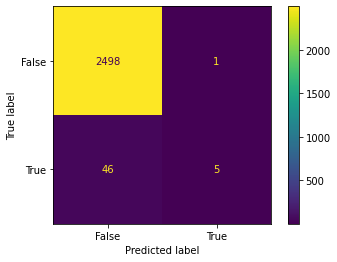

In [24]:
#Class weights- calculated manually defined weights: max depth=5
numberOfPasses=onlyFails.value_counts()[0]
numberOfFails=onlyFails.value_counts()[1]
ratio=numberOfFails/numberOfPasses
print("Ratio: "+str(ratio))
clf=DecisionTreeClassifier(class_weight={True:0.02,False:1})
clf.max_depth=5
clf.fit(X_train,y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print("Area under curve: "+str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
predictions=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test]
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test,predictions))

Ratio: 0.02
Accuracy of Decision Tree classifier on training set: 0.98
Area under curve: 0.8378567113119758
Accuracy of Decision Tree classifier on test set: 0.98
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2499
        True       0.58      0.65      0.61        51

    accuracy                           0.98      2550
   macro avg       0.79      0.82      0.80      2550
weighted avg       0.98      0.98      0.98      2550



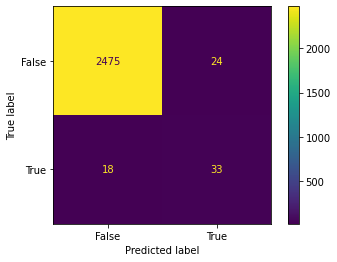

In [25]:
#Class weights- calculated manually defined weights: max depth=20
numberOfPasses=onlyFails.value_counts()[0]
numberOfFails=onlyFails.value_counts()[1]
ratio=numberOfFails/numberOfPasses
print("Ratio: "+str(ratio))
clf=DecisionTreeClassifier(class_weight={True:0.02,False:1})
clf.max_depth=20
clf.fit(X_train,y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print("Area under curve: "+str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))
predictions=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
mapped_y_test=['Pass' if x else 'Fail' for x in y_test]
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test,predictions))

# Improving the results
Find an improvment which will increase the performance in terms of model's accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Explain in words what did you change, document the results before and after you suggested improvment

In [26]:
#Q8
from sklearn.metrics import accuracy_score
print("The current accuracy:")
accuracy_score(y_test, predictions,normalize=True, sample_weight=None)

The current accuracy:


0.9835294117647059

First try to improve the results:
* Lets examine the performance of other tranning models

In [27]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights='uniform')
knn.fit(X_train,y_train)
print("KNN:\n")
print("Original data:\n")
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print("\nOversampling:\n")
knn.fit(X_train_oversample,y_train_oversample)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_oversample, y_train_oversample)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_oversample, y_test_oversample)))

print("\nUndersampling:\n")
knn.fit(X_train_undersample,y_train_undersample)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_undersample, y_train_undersample)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_undersample, y_test_undersample)))


KNN:

Original data:

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.99

Oversampling:

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.99

Undersampling:

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.96


In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

print("Naive Bayes:\n")
print("Original data:\n")
gnb.fit(X_train,y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

print("\nOversampling:\n")
gnb.fit(X_train_oversample,y_train_oversample)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train_oversample, y_train_oversample)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test_oversample, y_test_oversample)))

print("\nUndersampling:\n")
gnb.fit(X_train_undersample,y_train_undersample)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train_undersample, y_train_undersample)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test_undersample, y_test_undersample)))

Naive Bayes:

Original data:

Accuracy of GNB classifier on training set: 0.98
Accuracy of GNB classifier on test set: 0.97

Oversampling:

Accuracy of GNB classifier on training set: 0.95
Accuracy of GNB classifier on test set: 0.95

Undersampling:

Accuracy of GNB classifier on training set: 0.95
Accuracy of GNB classifier on test set: 0.97


In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
print("Random forest:\n")

print("Original data:\n")
clf.fit(X_train,y_train)
print('Accuracy of rf classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

print("\nOversampling:\n")
clf.fit(X_train_oversample,y_train_oversample)
print('Accuracy of rf classifier on training set: {:.2f}'
     .format(clf.score(X_train_oversample, y_train_oversample)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))

print("\nUndersampling:\n")
clf.fit(X_train_undersample,y_train_undersample)
print('Accuracy of rf classifier on training set: {:.2f}'
     .format(clf.score(X_train_undersample, y_train_undersample)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))

Random forest:

Original data:

Accuracy of rf classifier on training set: 1.00
Accuracy of rf classifier on test set: 0.99

Oversampling:

Accuracy of rf classifier on training set: 1.00
Accuracy of rf classifier on test set: 1.00

Undersampling:

Accuracy of rf classifier on training set: 1.00
Accuracy of rf classifier on test set: 0.98


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
print("Boosting algorithms:\n")

print("Original data:\n")
clf.fit(X_train, y_train)
print('Accuracy of XGBClassifier classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

print("\nOversampling:\n")
clf.fit(X_train_oversample, y_train_oversample)
print('Accuracy of XGBClassifier classifier on training set: {:.2f}'
     .format(clf.score(X_train_oversample, y_train_oversample)))
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))

print("\nUndersampling:\n")
clf.fit(X_train_undersample, y_train_undersample)
print('Accuracy of XGBClassifier classifier on training set: {:.2f}'
     .format(clf.score(X_train_undersample, y_train_undersample)))
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))

Boosting algorithms:

Original data:

Accuracy of XGBClassifier classifier on training set: 1.00
Accuracy of XGBClassifier classifier on test set: 0.99

Oversampling:

Accuracy of XGBClassifier classifier on training set: 0.99
Accuracy of XGBClassifier classifier on test set: 0.99

Undersampling:

Accuracy of XGBClassifier classifier on training set: 1.00
Accuracy of XGBClassifier classifier on test set: 0.97


# As it seems, the best performance, on the given data, is for the use of:
# Random Forest

More options to try:
* Feature engineering: scaling

In [31]:
selectedKBest=SelectKBest(f_classif,k=20).fit_transform(merged_data_frame_withoutDid,onlyFails)
selectedKBest

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(selectedKBest,onlyFails,random_state=0,shuffle=True)

from sklearn.metrics import roc_auc_score
clf=DecisionTreeClassifier()
clf.max_depth=20
clf.fit(X_train,y_train)

print("After taking more features: DecisionClassifierTree\n")

print("OriginalData:")
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print("Area under curve: "+str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

print("\nOverfitting:\n")
over_sampler=RandomOverSampler(random_state=42)
X_res_oversample,y_res_oversample=over_sampler.fit_resample(selectedKBest,onlyFails)
X_train_oversample,X_test_oversample,y_train_oversample,y_test_oversample=train_test_split(X_res_oversample,y_res_oversample,random_state=0,shuffle=True)
clf.fit(X_train_oversample,y_train_oversample)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))
print("Area under curve: "+str(roc_auc_score(y_test_oversample, clf.predict_proba(X_test_oversample)[:, 1])))
predictions=clf.predict(X_test_oversample)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_oversample, y_test_oversample)))

print("\nUnderfitting:\n")
under_sampler=RandomUnderSampler(random_state=42)
X_res_undersample,y_res_undersample=under_sampler.fit_resample(selectedKBest,onlyFails)
X_train_undersample,X_test_undersample,y_train_undersample,y_test_undersample=train_test_split(X_res_undersample,y_res_undersample,random_state=0,shuffle=True)
clf.fit(X_train_undersample,y_train_undersample)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))
print("Area under curve: "+str(roc_auc_score(y_test_undersample, clf.predict_proba(X_test_undersample)[:, 1])))
predictions=clf.predict(X_test_undersample)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_undersample, y_test_undersample)))


After taking more features: DecisionClassifierTree

OriginalData:
Accuracy of Decision Tree classifier on training set: 0.99
Area under curve: 0.8291316526610644

Overfitting:

Accuracy of Decision Tree classifier on training set: 0.99
Area under curve: 0.9950460504493197
Accuracy of Decision Tree classifier on test set: 0.99

Underfitting:

Accuracy of Decision Tree classifier on training set: 0.94
Area under curve: 0.9373737373737373
Accuracy of Decision Tree classifier on test set: 0.94


# After adding more features:
# The performance of the model was improved!!